### Imports

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Preprocessing

In [ ]:
# Imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

In [61]:
# Load Data
data = pd.read_csv('data/large_train.csv')
data.head()

,overall_rating,firm,date_review,job_title,location,headline,pros,cons,year
0,1,Google,2020-11-18,Intern,NaN,intern thing,i mean there was a bunch of free stuff,idk there was not really any,2020
1,1,McDonald-s,2019-06-22,Cashier,"Baltimore, MD",Terrible just like the rumors,"its a jobs, free foods once in a while","toxic customers, toxic and ratchet coworkers, ...",2019
2,1,IBM,2014-03-20,Technical Lead,Pune,DOn expect any increments,"Work from home, work life balance",Long list\r1. No increments\r2. still working ...,2014
3,1,Oracle,2021-05-18,Senior Sales Enablement Manager,"London, England, England",People leave managers not companies,Some great colleagues who are skilled and dedi...,"Inexperienced, incompetent middle and senior m...",2021
4,1,IBM,2009-06-01,,NaN,IBM not what is once was.,Telecommuting. Semi-flexible working hours (a...,Poor remuneration. Poor employee recognition....,2009


In [62]:
# Remove unnecessary columns from data
cols_to_drop = ['date_review', 'location', 'job_title']
data.drop(columns=cols_to_drop, inplace=True)
data.head()

,overall_rating,firm,headline,pros,cons,year
0,1,Google,intern thing,i mean there was a bunch of free stuff,idk there was not really any,2020
1,1,McDonald-s,Terrible just like the rumors,"its a jobs, free foods once in a while","toxic customers, toxic and ratchet coworkers, ...",2019
2,1,IBM,DOn expect any increments,"Work from home, work life balance",Long list\r1. No increments\r2. still working ...,2014
3,1,Oracle,People leave managers not companies,Some great colleagues who are skilled and dedi...,"Inexperienced, incompetent middle and senior m...",2021
4,1,IBM,IBM not what is once was.,Telecommuting. Semi-flexible working hours (a...,Poor remuneration. Poor employee recognition....,2009


In [63]:
# Remove rows with missing values in following columns
cols = ['firm', 'headline', 'pros', 'cons']
len_before = len(data)
df = data.dropna(subset=cols)
len_after = len(df)
print("Rows Dropped: ", len_before - len_after)


Rows Dropped:  1533


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercase and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Removing stopwords
    # tokens = [word for word in tokens if not word in stop_words]
    
    return ' '.join(tokens)

df['headline'] = df['headline'].apply(preprocess)
df['pros'] = df['pros'].apply(preprocess)
df['cons'] = df['cons'].apply(preprocess)

In [65]:
df.head()

,overall_rating,firm,headline,pros,cons,year
0,1,Google,intern thing,i mean there was a bunch of free stuff,idk there was not really any,2020
1,1,McDonald-s,terrible just like the rumors,its a jobs free foods once in a while,toxic customers toxic and ratchet coworkers di...,2019
2,1,IBM,don expect any increments,work from home work life balance,long list no increments still working old tech...,2014
3,1,Oracle,people leave managers not companies,some great colleagues who are skilled and dedi...,inexperienced incompetent middle and senior ma...,2021
4,1,IBM,ibm not what is once was,telecommuting working hours at times that abou...,poor remuneration poor employee recognition no...,2009


## Sentiment Analysis - Constructing Features

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sid.polarity_scores(str(text).lower())['compound']

# Constructing Features
df['headline_sentiment'] = df['headline'].apply(get_sentiment_score)
df['pros_sentiment'] = df['pros'].apply(get_sentiment_score)
df['cons_sentiment'] = df['cons'].apply(get_sentiment_score)

df['total_sentiment'] = df['headline_sentiment'] + df['pros_sentiment'] + df['cons_sentiment']
df['avg_sentiment'] = df['total_sentiment'] / 3

df['pros_length'] = df['pros'].apply(lambda x: len(x.split()))
df['cons_length'] = df['cons'].apply(lambda x: len(x.split()))

In [67]:
# Save sentimented data
csv_post_sentiment = './sentimented_data.csv'
df.to_csv(csv_post_sentiment, index=False)

## Training

In [68]:
# Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix

from ISLP import confusion_table

### Feature and Target Data

In [69]:
df = pd.read_csv("./sentimented_data.csv")

data_copy = df

# Convert firm to numerical value
le = LabelEncoder()
df['firm'] = le.fit_transform(df['firm'])
df['year'] = le.fit_transform(df['year'])

df.head()

,overall_rating,firm,headline,pros,cons,year,headline_sentiment,pros_sentiment,cons_sentiment,total_sentiment,avg_sentiment,pros_length,cons_length
0,1,148,intern thing,i mean there was a bunch of free stuff,idk there was not really any,12,0.0000,0.5106,-0.1027,0.4079,0.135967,9,6
1,1,229,terrible just like the rumors,its a jobs free foods once in a while,toxic customers toxic and ratchet coworkers di...,11,-0.1531,0.5106,-0.4404,-0.0829,-0.027633,9,8
2,1,179,don expect any increments,work from home work life balance,long list no increments still working old tech...,6,0.0000,0.0000,-0.1531,-0.1531,-0.051033,6,58
3,1,268,people leave managers not companies,some great colleagues who are skilled and dedi...,inexperienced incompetent middle and senior ma...,13,-0.0516,0.9062,-0.6705,0.1841,0.061367,15,18
4,1,179,ibm not what is once was,telecommuting working hours at times that abou...,poor remuneration poor employee recognition no...,1,0.0000,0.0000,0.0516,0.0516,0.017200,18,47


In [70]:
features_to_drop = ['overall_rating', 'headline', 'pros', 'cons', 'avg_sentiment', 'year']

y = df['overall_rating']
X = df.drop(columns=features_to_drop)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Neural Network

In [71]:
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='logistic', max_iter=1000,solver='adam', random_state=42)
nn_model.fit(X_train, y_train)

y_pred_train = np.round(np.clip(nn_model.predict(X_train), 1, 5))
y_pred_test = np.round(np.clip(nn_model.predict(X_test), 1, 5))

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'Train MSE: {mse_train}')
print(f'Train R2: {r2_train}')

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test MSE: {mse_test}')
print(f'Test R2: {r2_test}')


/opt/homebrew/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Train MSE: 0.8939873060613431
Train R2: 0.27363177022111884
Test MSE: 0.9005557004433566
Test R2: 0.26762574476633516


### Random Forest Regressor

In [72]:
rf1_model = RandomForestRegressor(random_state=42)
rf1_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [73]:
rf1_model = RandomForestRegressor(random_state=42)
rf1_model.fit(X_train, y_train)

y_pred_train = np.round(np.clip(rf1_model.predict(X_train), 1, 5))
y_pred_test = np.round(np.clip(rf1_model.predict(X_test), 1, 5))

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f'Train MSE: {mse_train}')
print(f'Train R2: {r2_train}')

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'Test MSE: {mse_test}')
print(f'Test R2: {r2_test}')

Train MSE: 0.14479415607375626
Train R2: 0.8823541742522185
Test MSE: 0.8638734527654623
Test R2: 0.2974574740088114


### Confusion Matrix

In [94]:
confusion_table(y_train, y_pred_train)

# confusion_table(y_test, y_pred_test)

Truth,1.0,2.0,3.0,4.0,5.0
Predicted,,,,,
1.0,10926,9898,267,56,0
2.0,0,19573,9760,236,0
3.0,0,858,84094,9217,31
4.0,0,11,4070,134713,742
5.0,0,2,259,19457,94603


## Predictions

In [76]:
def process(data):
    data.drop(columns=['overall_rating', 'date_review', 'job_title', 'location'], inplace=True)
    
    # Check for missing values in the provided columns
    cols = ['headline', 'pros', 'cons']
    data[cols].isna().any()

    data['headline'] = data['headline'].fillna('')
    data['pros'] = data['pros'].fillna('')  
    data['cons'] = data['cons'].fillna('')

    # Construct features
    data['headline'].apply(preprocess)
    data['pros'].apply(preprocess)
    data['cons'].apply(preprocess)

    data['headline_sentiment'] = data['headline'].apply(get_sentiment_score)
    data['pros_sentiment'] = data['pros'].apply(get_sentiment_score)
    data['cons_sentiment'] = data['cons'].apply(get_sentiment_score)
    data['total_sentiment'] = data['headline_sentiment'] + data['pros_sentiment'] + data['cons_sentiment']
    data['pros_length'] = data['pros'].apply(lambda x: len(x.split()))
    data['cons_length'] = data['cons'].apply(lambda x: len(x.split()))
    
    data = data.drop(columns=['headline', 'pros', 'cons', 'year'])
    return data

In [77]:
data_pred = pd.read_csv('data/test_data.csv')
data_pred.head()

# Preprocess
data_pred = process(data_pred)
data_pred['firm'] = le.fit_transform(data_pred['firm'])

# Predict
predictions = rf1_model.predict(data_pred)

# Save Predictions
predicted_data = pd.DataFrame(predictions, columns=["Overall Rating"])
predicted_data.to_csv("data/predictions.csv", index=False, header=False)

## Graphs

### Feature Importance

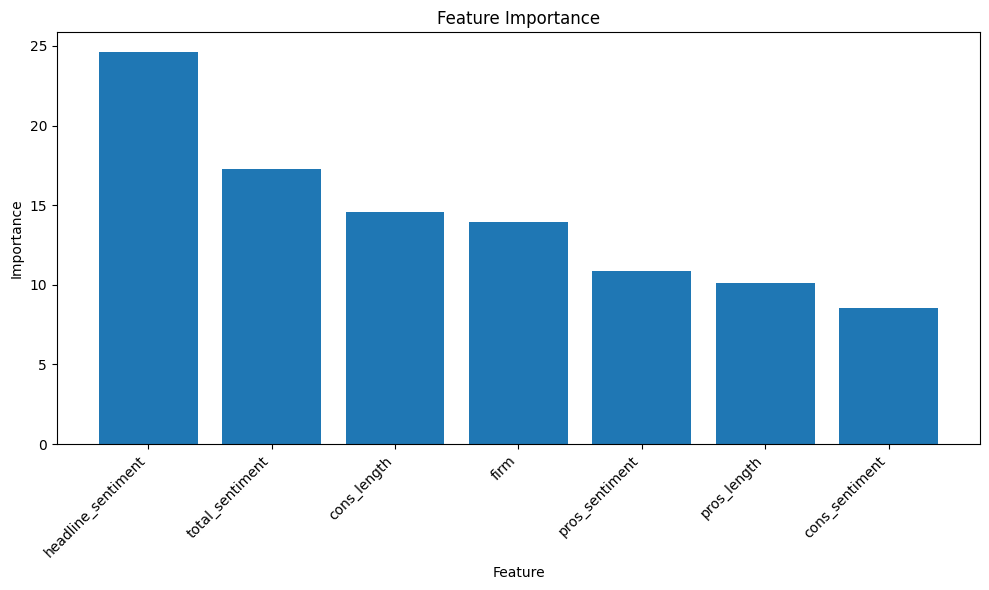

In [78]:
# Get feature importances
feature_importances = rf1_model.feature_importances_ * 100
feature_names = rf1_model.feature_names_in_

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

### Feature Correlation

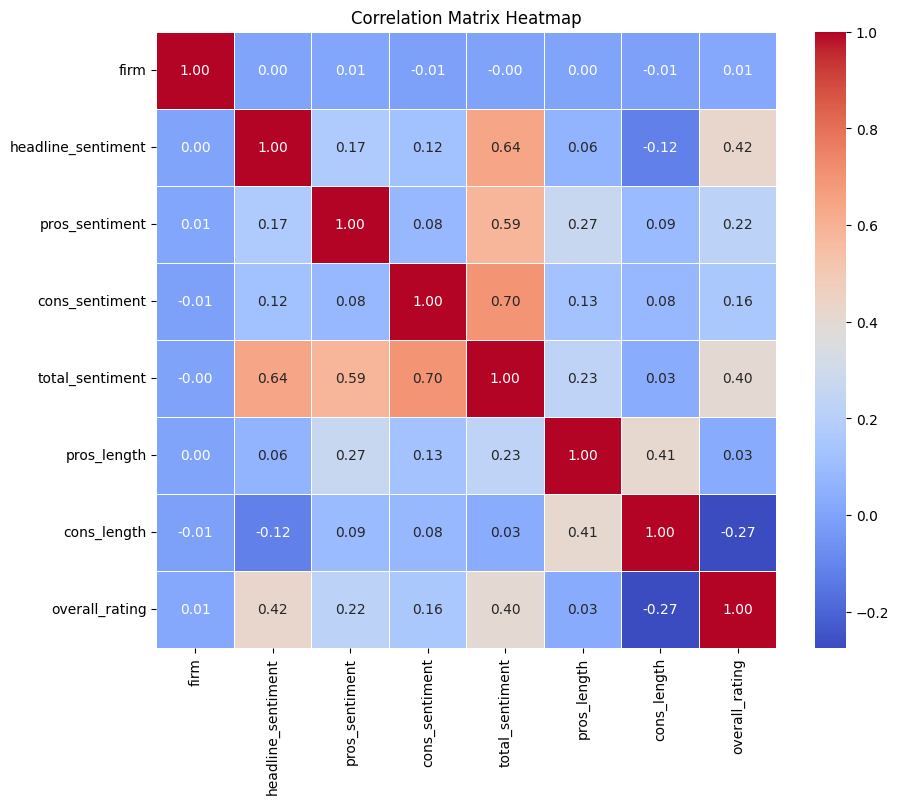

In [79]:
cols = np.append(feature_names,'overall_rating')
correlation_matrix = data_copy[cols].corr()

pd.set_option('display.max_columns', None)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Feature Distribution

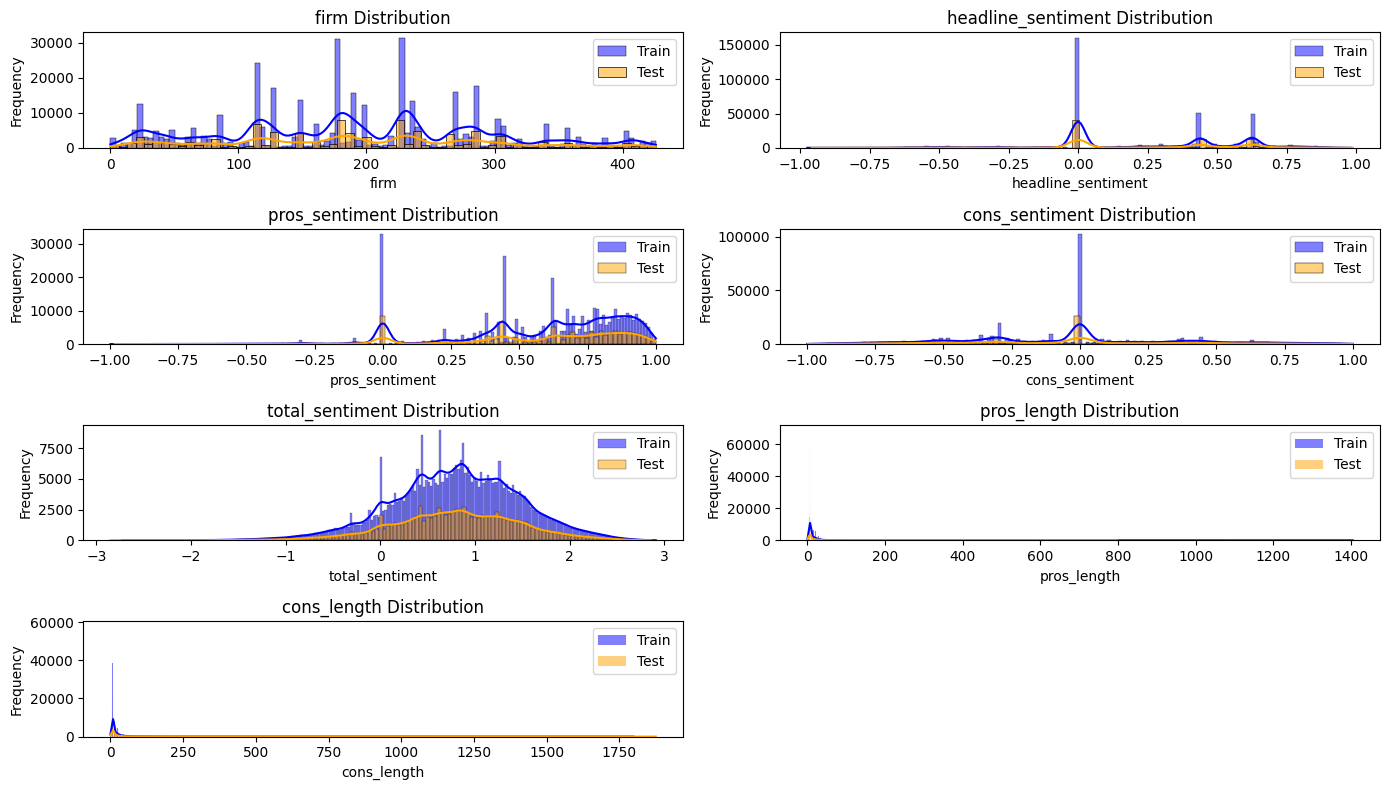

In [80]:
plt.figure(figsize=(14, 8))

# print(X_train.columns)

num_cols = len(X_train.columns)
num_rows = (num_cols // 2) + (num_cols % 2)  # Calculate the number of rows needed for the subplot grid

for i, col in enumerate(X_train.columns):
    plt.subplot(num_rows, 2, i+1)  # Adjust the subplot layout according to the number of features
    sns.histplot(X_train[col], color='blue', kde=True, label='Train', alpha=0.5)
    sns.histplot(X_test[col], color='orange', kde=True, label='Test', alpha=0.5)
    plt.title(f'{col} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

### Prediction Errors

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.1)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

### Word Clouds

In [82]:
data = pd.read_csv('data/small_train.csv')

stop_words = set(stopwords.words('english'))

def process_text(text):
    tokens = word_tokenize(str(text))
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if not word in stop_words]
    return ' '.join(tokens)
    
data['headline'] = data['headline'].apply(process_text)
data['pros'] = data['pros'].apply(process_text)
data['cons'] = data['cons'].apply(process_text)

data_rating = []
data_rating.append(data[data['overall_rating'] == 1])
data_rating.append(data[data['overall_rating'] == 2])
data_rating.append(data[data['overall_rating'] == 3])
data_rating.append(data[data['overall_rating'] == 4])
data_rating.append(data[data['overall_rating'] == 5])


In [ ]:
for i in range(5):
    words = pd.concat([data_rating[0]['headline'], data_rating[0]['pros'], data_rating[0]['cons']])
    
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    
    # Plot word clouds
    plt.figure(figsize=(6, 4))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {i + 1} star reviews')
    plt.axis('off')
    plt.show()

## Insights

In [84]:
# Imports
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

In [85]:
df = pd.read_csv("./sentimented_data.csv")

# Split data based on high and low ratings
high_ratings = df[(df['overall_rating'] == 4) | (df['overall_rating'] == 5)]
low_ratings = df[(df['overall_rating'] == 1) | (df['overall_rating'] == 2)]

In [86]:
# Remove stop words
stop_words = stopwords.words('english') + ['work']

def remove_stop_words(text):
    tokens = [word for word in str(text).split() if not word in stop_words]
    return tokens

high_pros = high_ratings['pros'].apply(remove_stop_words)
low_cons = low_ratings['cons'].apply(remove_stop_words)

In [87]:
# Function to extract trigrams from text and convert them into phrases
def extract_trigram_phrases(text_series):
    trigram_phrases = []
    for text in text_series:
        trigrams = ngrams(text, 3)
        phrases = [' '.join(trigram) for trigram in trigrams]
        trigram_phrases.extend(phrases)
    return trigram_phrases

# Extract trigrams from high pros and low cons text
high_pros_trigrams = extract_trigram_phrases(high_pros)
low_cons_trigrams = extract_trigram_phrases(low_cons)

# Count the occurrences of each trigram
high_pros_trigrams_counts = Counter(high_pros_trigrams)
low_cons_trigrams_counts = Counter(low_cons_trigrams)

# Print the most common trigrams for high pros and low cons
print("Top trigrams in high pros:")
for trigram, count in high_pros_trigrams_counts.most_common(8):
    print(trigram, ":", count)

print("\nTop trigrams in low cons:")
for trigram, count in low_cons_trigrams_counts.most_common(8):
    print(trigram, ":", count)

Top trigrams in high pros:
good life balance : 4966
life balance good : 2453
great life balance : 1942
good working environment : 1876
flexible working hours : 1809
great people great : 1346
good pay good : 1151
place start career : 1086

Top trigrams in low cons:
long working hours : 324
high staff turnover : 179
poor life balance : 152
get things done : 125
hours per week : 112
get anything done : 108
high turnover staff : 107
could care less : 105


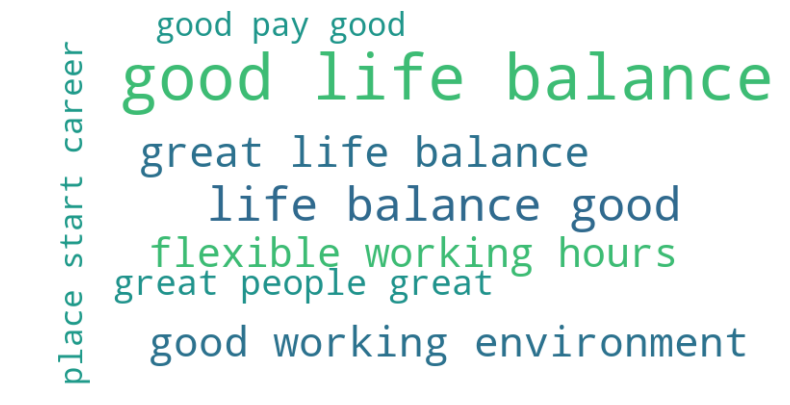

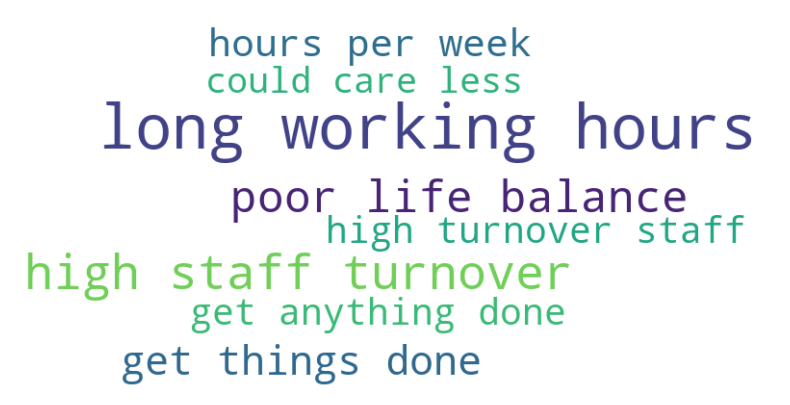

In [88]:
# Function to generate word cloud from a dictionary of word frequencies
def generate_wordcloud(word_freq_dict):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud for the top 10 most common high pros trigrams
generate_wordcloud(dict(high_pros_trigrams_counts.most_common(8)))

# Generate word cloud for the top 10 most common low cons trigrams
generate_wordcloud(dict(low_cons_trigrams_counts.most_common(8)))